In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PREPROCESSING
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# MODELS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

# CV
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# METRICS
from sklearn.metrics import r2_score, root_mean_squared_error, median_absolute_error

# DON'T USE SCIENTIFIC NOTATION
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
RANDOM_STATE = 42

# Data

In [3]:
df = pd.read_csv('Knn Imputed/North Ave.csv', index_col='Date_Time')
df.index = pd.to_datetime(df.index)
df.drop(columns=['Station_Name'], inplace=True)
df = df.astype('uint16')
df

,Entry,Year,Month,Day,Hour,Weekday,Is_Holiday
Date_Time,,,,,,,
2022-04-18 04:00:00,566,2022,4,18,4,1,0
2022-04-18 05:00:00,2508,2022,4,18,5,1,0
2022-04-18 06:00:00,2889,2022,4,18,6,1,0
2022-04-18 07:00:00,2607,2022,4,18,7,1,0
2022-04-18 08:00:00,2269,2022,4,18,8,1,0
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,334,2023,12,31,19,7,1
2023-12-31 20:00:00,0,2023,12,31,20,7,1
2023-12-31 21:00:00,0,2023,12,31,21,7,1


# Splitting

In [4]:
TRAIN_SIZE = 0.8
SPLIT_INDEX = int(TRAIN_SIZE * len(df.index))

In [5]:
tss = TimeSeriesSplit(n_splits=10)

In [48]:
def create_Lag_Features(save_as_csv = False, path=None):
    output = df.copy()
    output['Entry Last Hour'] = output['Entry'].diff(1)
    output['Entry Last 2 Hours'] = output['Entry'].diff(2)
    output['Entry Yesterday'] = output['Entry'].diff(20)
    output['Entry Last Week'] = output['Entry'].diff(20*7)
    output.dropna(inplace=True)

    if save_as_csv:
        output.to_csv(path)
    
    SPLIT_INDEX = int(TRAIN_SIZE * len(output.index))

    lag_train = output[:SPLIT_INDEX]
    lag_test = output[SPLIT_INDEX:]

    X_train_lag = lag_train.drop(columns=['Entry'])
    X_test_lag = lag_test.drop(columns=['Entry'])
    y_train_lag = lag_train['Entry']
    y_test_lag = lag_test['Entry']

    return X_train_lag, X_test_lag, y_train_lag, y_test_lag

In [7]:
train = df[:SPLIT_INDEX]
test = df[SPLIT_INDEX:]

X_train = train.drop(columns=['Entry'])
X_test = test.drop(columns=['Entry'])
y_train = train['Entry']
y_test = test['Entry']

print('X_train\t:', X_train.shape)
print('X_test\t:', X_test.shape)
print('y_train\t:', y_train.shape)
print('y_test\t:', y_test.shape)

X_train	: (9968, 6)
X_test	: (2492, 6)
y_train	: (9968,)
y_test	: (2492,)


### Results storage

In [8]:
df_predictions_train = pd.DataFrame(y_train)
df_predictions_test = pd.DataFrame(y_test)
df_scores = pd.DataFrame(columns=['Train R2', 'Test R2', 
                                  'Train MedAE', 'Test MedAE',
                                  'Train RMSE', 'Test RMSE',
                                  'Best Params'
                                 ])

### Helper Functions for Results Storing

In [9]:
def call_predict(model, type):
    df_predictions_train[type] = model.predict(X_train)
    df_predictions_test[type] = model.predict(X_test)

def get_score(type, best_params, train_correct = None, test_correct = None, train_predict=None, test_predict=None):
    if train_correct is None:
        train_correct = y_train
        test_correct = y_test
        train_predict = df_predictions_train[type]
        test_predict = df_predictions_test[type]
    
    df_scores.loc[type] = [
        r2_score(train_correct, train_predict),
        r2_score(test_correct, test_predict),
        median_absolute_error(train_correct, train_predict),
        median_absolute_error(test_correct, test_predict),
        root_mean_squared_error(train_correct, train_predict),
        root_mean_squared_error(test_correct, test_predict),
        best_params
    ]

    return df_scores

def plot_predictions(df, title, cols=['Entry'], LIMIT=100):
    df[cols][:LIMIT].plot()
    plt.title(title)
    plt.show()

In [10]:
def summarize(model, model_name, best_params):
    call_predict(model, model_name)
    plot_predictions(df_predictions_test, model_name + ' Test Predictions', ['Entry', model_name])
    return get_score(model_name, best_params)

# 1. KNN
KnnRegressor makes predictions based on the mean of the values of the closest n neighbors. 

GridSearch will be used since it's only one hyperparameter that we're iterating through.
<br>Start at 2, since 1 neighbor is an obvious overfit.

In addition, use a pipeline to add a scaler preprocessing since Knn's distance measure will be affected by different ranges.

We can do a comparison to check their difference with and without scaling.

In [11]:
params_Knn = {'n_neighbors' : range(2, 20)}

cv_Knn = GridSearchCV(KNeighborsRegressor(n_jobs=-1), 
                      params_Knn, 
                      scoring='r2', 
                      cv=tss)
cv_Knn.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=KNeighborsRegressor(n_jobs=-1),
             param_grid={'n_neighbors': range(2, 20)}, scoring='r2')

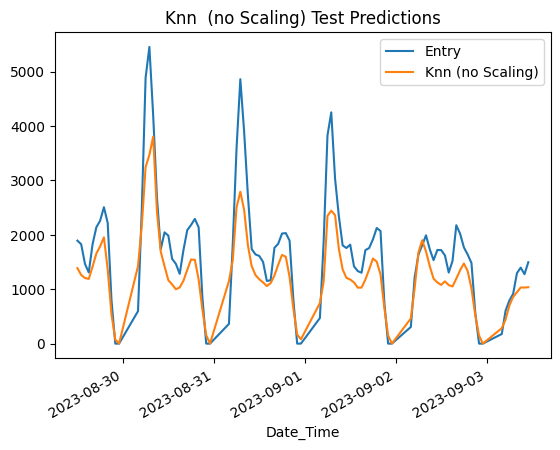

In [12]:
call_predict(cv_Knn.best_estimator_, 'Knn (no Scaling)')
plot_predictions(df_predictions_test, 'Knn  (no Scaling) Test Predictions', ['Entry', 'Knn (no Scaling)'])

In [13]:
get_score('Knn (no Scaling)', cv_Knn.best_params_)

,Train R2,Test R2,Train MedAE,Test MedAE,Train RMSE,Test RMSE,Best Params
Knn (no Scaling),0.929,0.590,91.833,387.250,231.210,730.227,{'n_neighbors': 6}


### Knn Results
Knn is quite remarkable for a lazy learner.
<br>It captures the differing rises and falls unique to each different day.

However it's certainly overfit with testing errors being signifcantly higher.

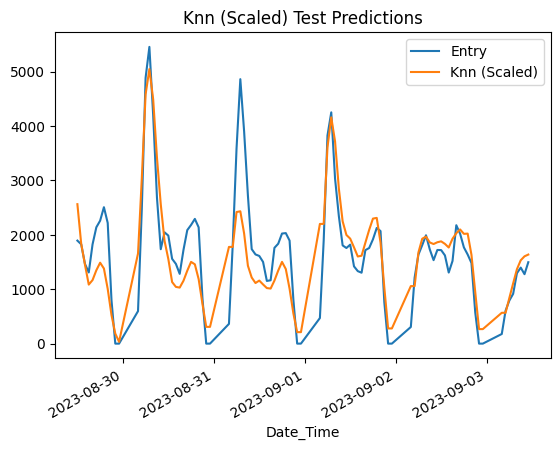

,Train R2,Test R2,Train MedAE,Test MedAE,Train RMSE,Test RMSE,Best Params
Knn (no Scaling),0.929,0.590,91.833,387.250,231.210,730.227,{'n_neighbors': 6}
Knn (Scaled),0.894,0.726,80.333,252.667,282.559,596.902,{'model__n_neighbors': 3}


In [14]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])

params_knn = {
    'model__n_neighbors' : range(2, 20)
}
cv_knn = GridSearchCV(pipe_knn, params_knn, scoring='r2')
cv_knn.fit(X_train, y_train)

summarize(cv_knn, 'Knn (Scaled)', cv_knn.best_params_)

There is a significant difference in performance when scaling.

The test set predictions have increased in score, while the overfitting is also decreased.

# 2. Polynomial Regression Models
Considering that we have a daily seasonal pattern occuring every 20 hours, it might be possible to capture this behavior with a polynomial curve.

We could try the basic linear regression and loss adjusting SGDRegressor.

## 2.1 Linear Regression 
The linear lines unfortunately seem too simple. There's also not very much tweaking we can do with the hyperparamters.

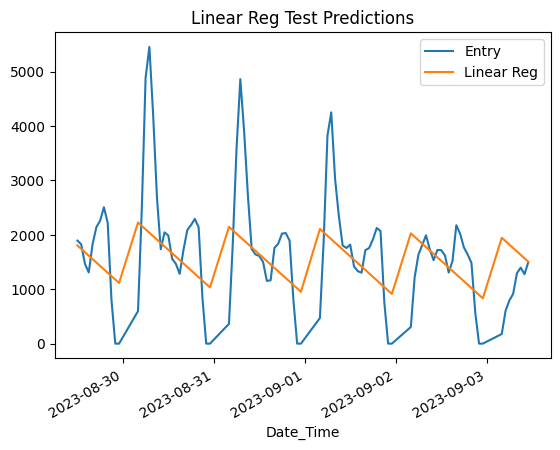

,Train R2,Test R2,Train MedAE,Test MedAE,Train RMSE,Test RMSE,Best Params
Knn (no Scaling),0.929,0.590,91.833,387.250,231.210,730.227,{'n_neighbors': 6}
Knn (Scaled),0.894,0.726,80.333,252.667,282.559,596.902,{'model__n_neighbors': 3}
Linear Reg,0.234,0.186,475.069,604.949,759.156,1029.203,"{'copy_X': True, 'fit_intercept': True, 'n_job..."


In [15]:
model_Linear = LinearRegression(n_jobs=-1)
model_Linear.fit(X_train, y_train)

summarize(model_Linear, 'Linear Reg', model_Linear.get_params())

## 2.2 Stochastic Gradient Descent
SGD is able to provide us a curve improved with a loss function.

However it's extemely difficult to fine tune the hyperparameters often ranging in the decimals.

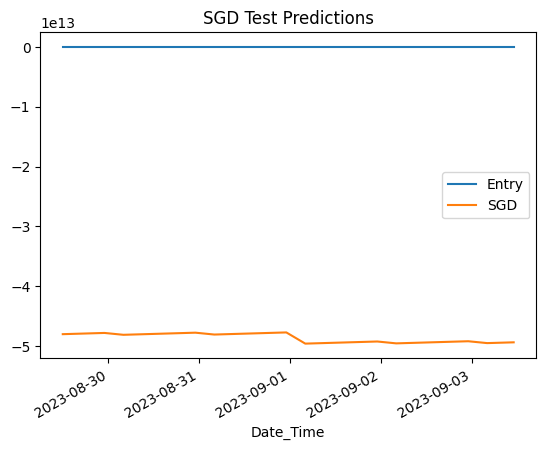

,Train R2,Test R2,Train MedAE,Test MedAE,Train RMSE,Test RMSE,Best Params
Knn (no Scaling),0.929,0.590,91.833,387.250,231.210,730.227,{'n_neighbors': 6}
Knn (Scaled),0.894,0.726,80.333,252.667,282.559,596.902,{'model__n_neighbors': 3}
Linear Reg,0.234,0.186,475.069,604.949,759.156,1029.203,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
SGD,-3141125790376840396800.000,-1822655039451084619776.000,48598930260243.016,48707531507528.625,48607620683547.469,48709170048702.992,"{'tol': 0.01, 'eta0': 0.001, 'epsilon': 0.1, '..."


In [16]:
params_SGD = {
    'alpha' : np.arange(0.0001, 1, 0.001),
    'tol' : [0.1, 0.01, 0.001],
    'eta0' : [0.1, 0.01, 0.001],
    'epsilon' : [0.1, 0.01, 0.001]
}

cv_SGD = RandomizedSearchCV(SGDRegressor(random_state=RANDOM_STATE), params_SGD, cv=tss, scoring='r2', n_jobs=-1)
cv_SGD.fit(X_train, y_train)

summarize(cv_SGD.best_estimator_, 'SGD', cv_SGD.best_params_)

### The most impressive model so far has been Knn

Let's try BlackBox models to see if we can get better results.

Our linear regressors just don't appear complex enough to capture the 20 hour seasons.

# 3. Random Forest
Each individual tree has a chance of overfitting unless controlled by the hyperparameters.

This may be exactly what we want since the previous polynomial regressors were too basic, while our Knn seems to perform well when averaging with only from a few neighbors.

No more scaling, since trees are scale invariant.

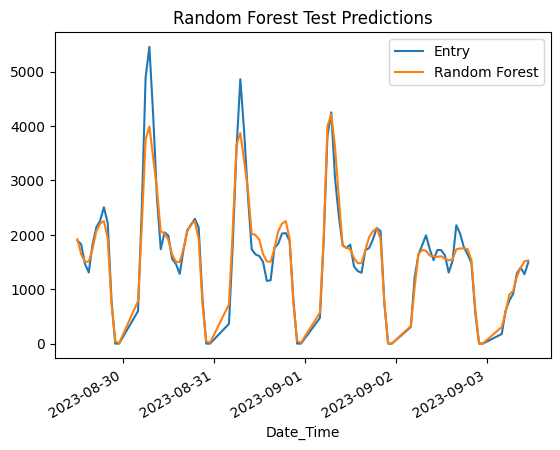

,Train R2,Test R2,Train MedAE,Test MedAE,Train RMSE,Test RMSE,Best Params
Knn (no Scaling),0.929,0.590,91.833,387.250,231.210,730.227,{'n_neighbors': 6}
Knn (Scaled),0.894,0.726,80.333,252.667,282.559,596.902,{'model__n_neighbors': 3}
Linear Reg,0.234,0.186,475.069,604.949,759.156,1029.203,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
SGD,-3141125790376840396800.000,-1822655039451084619776.000,48598930260243.016,48707531507528.625,48607620683547.469,48709170048702.992,"{'tol': 0.01, 'eta0': 0.001, 'epsilon': 0.1, '..."
Random Forest,0.925,0.853,74.846,207.274,237.564,437.582,"{'n_estimators': 100, 'min_samples_split': 0.0..."


In [17]:
params_rf = {
    'max_depth' : range(3, 18),
    'max_features' : range(2, 5),
    'n_estimators' : range(100, 300, 50),
    'min_samples_split' : np.arange(0.0001, 0.001, 0.0001),
    'min_samples_leaf' : np.arange(0.0001, 0.001, 0.0001)
}

cv_rf = RandomizedSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), params_rf, cv=tss, scoring='r2', random_state=RANDOM_STATE, n_jobs=-1, n_iter=50)
cv_rf.fit(X_train, y_train)

summarize(cv_rf.best_estimator_, 'Random Forest', cv_rf.best_params_)

### Lag Features
Lag refers to the relation to a previous time period.

We create the features and check its affect.

In [18]:
X_train_lag, X_test_lag, y_train_lag, y_test_lag = create_Lag_Features()

cv_rf.fit(X_train_lag, y_train_lag)
# summarize(cv_rf, 'Random Forest w/ Lag', cv_rf.best_params_, True)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(3, 18),
                                        'max_features': range(2, 5),
                                        'min_samples_leaf': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                                        'min_samples_split': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                                        'n_estimators': range(100, 300, 50)},
                   random_state=42, scoring='r2')

In [19]:
df_predictions_train_lag = y_train_lag.copy()
df_predictions_test_lag = y_test_lag.copy()

In [20]:
df_predictions_train_lag['RF'] = cv_rf.predict(X_train_lag)
df_predictions_test_lag['RF'] = cv_rf.predict(X_test_lag)

In [21]:
get_score('Random Forest w/ Lag', cv_rf.best_params_, 
          y_train_lag,
          y_test_lag,
          df_predictions_train_lag['RF'], 
          df_predictions_test_lag['RF'],
         )

,Train R2,Test R2,Train MedAE,Test MedAE,Train RMSE,Test RMSE,Best Params
Knn (no Scaling),0.929,0.590,91.833,387.250,231.210,730.227,{'n_neighbors': 6}
Knn (Scaled),0.894,0.726,80.333,252.667,282.559,596.902,{'model__n_neighbors': 3}
Linear Reg,0.234,0.186,475.069,604.949,759.156,1029.203,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
SGD,-3141125790376840396800.000,-1822655039451084619776.000,48598930260243.016,48707531507528.625,48607620683547.469,48709170048702.992,"{'tol': 0.01, 'eta0': 0.001, 'epsilon': 0.1, '..."
Random Forest,0.925,0.853,74.846,207.274,237.564,437.582,"{'n_estimators': 100, 'min_samples_split': 0.0..."
Random Forest w/ Lag,0.979,0.893,53.275,212.179,125.518,373.621,"{'n_estimators': 250, 'min_samples_split': 0.0..."


# 4. XGB
XGB is a gradient boosting forest that improves upon last iterations.

We'll be using a CV to compare whether the regular features or the one with lag features produce better results.

### Cross Validation for XGBoost

In [22]:
def XGB_cv(X_train, y_train):
    scores = []    
    for train_index, val_index in tss.split(y_train):
        
        model_XGB.fit(X_train.iloc[train_index], y_train.iloc[train_index],
                 eval_set=[(X_train.iloc[train_index], y_train.iloc[train_index]), (X_train.iloc[val_index], y_train.iloc[val_index])],
                     verbose=100)
        scores.append(
            r2_score(model_XGB.predict(X_train.iloc[val_index]),
                     y_train.iloc[val_index]
                    ))
    
    print('Crosss validation score R2: ', np.mean(scores))

In [23]:
model_XGB = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=50, random_state=RANDOM_STATE, eval_metric='rmse')

XGB_cv(X_train, y_train)

[0]	validation_0-rmse:580.98553	validation_1-rmse:629.67300
[57]	validation_0-rmse:39.37598	validation_1-rmse:288.34558
[0]	validation_0-rmse:593.12012	validation_1-rmse:590.01408
[100]	validation_0-rmse:39.82593	validation_1-rmse:248.92836
[105]	validation_0-rmse:38.69016	validation_1-rmse:249.34909
[0]	validation_0-rmse:588.49262	validation_1-rmse:588.25963
[81]	validation_0-rmse:56.85626	validation_1-rmse:179.82380
[0]	validation_0-rmse:585.93273	validation_1-rmse:751.26218
[86]	validation_0-rmse:59.16487	validation_1-rmse:490.72171
[0]	validation_0-rmse:616.36419	validation_1-rmse:646.79052
[53]	validation_0-rmse:84.77633	validation_1-rmse:571.58207
[0]	validation_0-rmse:621.53034	validation_1-rmse:602.51585
[55]	validation_0-rmse:99.91097	validation_1-rmse:461.45748
[0]	validation_0-rmse:621.29768	validation_1-rmse:794.79731
[89]	validation_0-rmse:90.77784	validation_1-rmse:564.57385
[0]	validation_0-rmse:645.21101	validation_1-rmse:571.34487
[53]	validation_0-rmse:122.39322	valid

In [24]:
XGB_cv(X_train_lag, y_train_lag)

[0]	validation_0-rmse:587.21508	validation_1-rmse:620.52445
[98]	validation_0-rmse:3.93270	validation_1-rmse:224.20977
[0]	validation_0-rmse:597.95698	validation_1-rmse:598.05941
[100]	validation_0-rmse:10.13028	validation_1-rmse:163.58550
[110]	validation_0-rmse:8.57982	validation_1-rmse:163.77540
[0]	validation_0-rmse:589.96974	validation_1-rmse:588.95688
[100]	validation_0-rmse:15.54576	validation_1-rmse:112.67549
[200]	validation_0-rmse:5.15675	validation_1-rmse:112.40136
[207]	validation_0-rmse:4.69928	validation_1-rmse:112.44357
[0]	validation_0-rmse:587.73623	validation_1-rmse:741.58755
[70]	validation_0-rmse:26.10378	validation_1-rmse:446.15033
[0]	validation_0-rmse:618.59486	validation_1-rmse:623.32374
[60]	validation_0-rmse:39.98793	validation_1-rmse:393.40267
[0]	validation_0-rmse:618.92741	validation_1-rmse:640.11697
[84]	validation_0-rmse:41.01637	validation_1-rmse:300.07534
[0]	validation_0-rmse:623.87968	validation_1-rmse:774.27461
[73]	validation_0-rmse:51.50951	validat

In [25]:
model_XGB.fit(X_train_lag, y_train_lag, 
              eval_set=[(X_train_lag, y_train_lag), (X_test_lag, y_test_lag)])
# summarize(model_XGB, 'XGB', model_XGB.get_params())

df_predictions_train_lag['XGB'] = model_XGB.predict(X_train_lag)
df_predictions_test_lag['XGB'] = model_XGB.predict(X_test_lag)

get_score('XGB w/ Lag', model_XGB.get_params(), 
          y_train_lag,
          y_test_lag,
          df_predictions_train_lag['XGB'], 
          df_predictions_test_lag['XGB'],
         )

[0]	validation_0-rmse:669.43334	validation_1-rmse:999.23207
[1]	validation_0-rmse:531.72792	validation_1-rmse:863.92762
[2]	validation_0-rmse:438.44278	validation_1-rmse:787.56188
[3]	validation_0-rmse:380.08849	validation_1-rmse:711.57362
[4]	validation_0-rmse:336.70049	validation_1-rmse:670.46640
[5]	validation_0-rmse:306.69807	validation_1-rmse:606.61716
[6]	validation_0-rmse:282.60155	validation_1-rmse:577.22825
[7]	validation_0-rmse:266.53127	validation_1-rmse:552.38292
[8]	validation_0-rmse:253.97240	validation_1-rmse:536.30817
[9]	validation_0-rmse:230.00186	validation_1-rmse:472.05591
[10]	validation_0-rmse:209.27409	validation_1-rmse:425.09184
[11]	validation_0-rmse:198.96749	validation_1-rmse:414.30095
[12]	validation_0-rmse:184.86927	validation_1-rmse:387.86457
[13]	validation_0-rmse:178.64039	validation_1-rmse:381.80240
[14]	validation_0-rmse:171.21263	validation_1-rmse:367.31087
[15]	validation_0-rmse:164.69241	validation_1-rmse:351.89353
[16]	validation_0-rmse:157.01516	v

,Train R2,Test R2,Train MedAE,Test MedAE,Train RMSE,Test RMSE,Best Params
Knn (no Scaling),0.929,0.590,91.833,387.250,231.210,730.227,{'n_neighbors': 6}
Knn (Scaled),0.894,0.726,80.333,252.667,282.559,596.902,{'model__n_neighbors': 3}
Linear Reg,0.234,0.186,475.069,604.949,759.156,1029.203,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
SGD,-3141125790376840396800.000,-1822655039451084619776.000,48598930260243.016,48707531507528.625,48607620683547.469,48709170048702.992,"{'tol': 0.01, 'eta0': 0.001, 'epsilon': 0.1, '..."
Random Forest,0.925,0.853,74.846,207.274,237.564,437.582,"{'n_estimators': 100, 'min_samples_split': 0.0..."
Random Forest w/ Lag,0.979,0.893,53.275,212.179,125.518,373.621,"{'n_estimators': 250, 'min_samples_split': 0.0..."
XGB w/ Lag,0.991,0.925,38.045,168.045,81.719,312.396,"{'objective': 'reg:squarederror', 'base_score'..."


In [26]:
assert False

AssertionError: 

# 6. Neural Networks
Neural Networks will be dependent on the number of layers.

We based the number of possible values per feature i.e. (Layer 1 : 20h, Layer 2: 7d, Layer 3: 12m)

In [ ]:
import torch.nn as nn
import torch.nn.init
import torch.optim as optim

In [ ]:
# Neural Network Class and Backprop Loop by Prof. Arren Matthew Antioquia
class NeuralNetwork(nn.Module):

    def __init__(self,
                 input_size,
                 num_classes,
                 list_hidden,
                 activation='ReLU'):

        super(NeuralNetwork, self).__init__()

        torch.set_grad_enabled(True)
        
        self.input_size = input_size
        self.num_classes = num_classes
        self.list_hidden = list_hidden
        self.activation = activation
    
    def create_network(self):
        layers = []

        layers.append(torch.nn.Linear(self.input_size, self.list_hidden[0]))
        layers.append(self.get_activation(mode = self.activation))
        
        # Iterate over other hidden layers just before the last layer
        for i in range(len(self.list_hidden) - 1):
            layers.append(torch.nn.Linear(self.list_hidden[i], self.list_hidden[i+1]))
            layers.append(self.get_activation(mode = self.activation))

        layers.append(torch.nn.Linear(self.list_hidden[-1], self.num_classes))

        # Add one last activation layer if necessary. 
        self.layers = nn.Sequential(*layers)

    
    def get_activation(self,
                       mode='ReLU'):
        activation = nn.ReLU(inplace=True)
        if mode == 'LReLU':
            activation = nn.LeakyReLU(inplace=True)
            
        return activation

    def init_weights(self):
        torch.manual_seed(2)

        # For each layer in the network
        for module in self.modules():

            # If it is a torch.nn.Linear layer
            if isinstance(module, nn.Linear):
                module.weight = nn.init.normal_(module.weight, mean=0, std=0.1)
                module.bias = torch.nn.init.constant_(module.bias, 0)
    
    def forward(self,
            x,
            verbose=False):

        logits = self.layers(x)
        return logits

Convert to tensors

In [ ]:
X_train_tensor = torch.tensor(X_train_lag.values, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_lag.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_lag.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test_lag.values, dtype=torch.float)

In [ ]:
model_nn = NeuralNetwork(input_size = X_train_tensor.shape[1],
              list_hidden=(20, 7, 12),
              num_classes = 1, 
              activation='ReLU').to("cuda")

model_nn.create_network()
model_nn.init_weights()

print(model_nn)

In [ ]:
predictions = model_nn.forward(X_train_tensor)

In [ ]:
criterion = nn.L1Loss().to("cuda")
loss = criterion(predictions.flatten(), y_train_tensor)

In [ ]:
optimizer = optim.Adam(model_nn.parameters(), lr=0.0001)

In [ ]:
predictions

In [ ]:
model_nn.forward(X_train_tensor)

In [ ]:
e = 0
max_epochs = 400
is_converged = False
previous_loss = 0
losses = []

# For each epoch
while e < max_epochs and is_converged is not True:    
    current_epoch_loss = 0

    X_batch = X_train_tensor
    y_batch = y_train_tensor
    
    # For each batch
    for X, y in zip(X_batch, y_batch):
        X = torch.Tensor(X)
        y = torch.Tensor(y)
        
        optimizer.zero_grad()
        predictions = model_nn(X)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        
        current_epoch_loss += loss.item()
    
    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)
    
    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 1:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

print('Done')

In [ ]:
model_nn.eval()

In [ ]:
predictions_train = model_nn.forward(X_train_tensor)
predictions_test = model_nn.forward(X_test_tensor)

In [ ]:
print(r2_score(predictions_train.detach(), y_train_lag))
print(r2_score(predictions_test.detach(), y_test_lag))

### Takes too long to backprop.
Best to stick with simpler models.

In [ ]:
get_score('Neural Network (7,12,20)', '(7, 12, 20, ReLU)', 
          train_correct = y_train_lag, 
          test_correct = y_test_lag, 
          train_predict=predictions_train.detach(), 
          test_predict=predictions_test.detach())

# Making the Final Models
Now that we know the best models, let's start making and saving these for each station dataset.

In [46]:
from os import listdir
from joblib import dump, load

In [28]:
model_XGB = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=50, random_state=RANDOM_STATE, eval_metric='rmse')
cv_rf = RandomizedSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), params_rf, cv=tss, scoring='r2', random_state=RANDOM_STATE, n_jobs=-1, n_iter=50)

In [52]:
for file in listdir('Knn Imputed'):
    if file[-3:] == 'csv':
        print(file)

        # OPENING AND ADJUSTING DATAFRAME
        df = pd.read_csv('Knn Imputed/' +file)
        df.drop(columns=['Station_Name'], inplace=True)
        df.set_index('Date_Time', inplace=True)
        df.index = pd.to_datetime(df.index)
        
        # LAG FEATURE CREATION
        X_train_lag, X_test_lag, y_train_lag, y_test_lag = create_Lag_Features(True, 'Dataset with Lag Features/' + file + '.csv')

        # # FITTING AND SAVING RF
        cv_rf.fit(X_train_lag, y_train_lag)
        dump(cv_rf.best_estimator_, 'Models/RF/' + file[:-4] + '.model')
        print('RF R2:',  r2_score(cv_rf.best_estimator_.predict(X_test_lag), y_test_lag))

        
        # FITTING AND SAVING XGB
        model_XGB.fit(X_train_lag, y_train_lag,
                     eval_set=[(X_train_lag, y_train_lag), (X_test_lag, y_test_lag)],
                     verbose=0)
        dump(model_XGB, 'Models/XGB/' + file[:-4] + '.model')
        print('XGB R2:',  r2_score(model_XGB.predict(X_test_lag), y_test_lag))

Ayala Ave.csv
RF R2: 0.9150910448037676
XGB R2: 0.9623960444558052
Boni Ave.csv
RF R2: 0.9177853149503211
XGB R2: 0.9595139809953285
Buendia.csv
RF R2: 0.9479917643324876
XGB R2: 0.9670333948855161
Cubao.csv
RF R2: 0.9257816460482251
XGB R2: 0.962257213323265
GMA Kamuning.csv
RF R2: 0.9695443786371942
XGB R2: 0.969556248176656
Guadalupe.csv
RF R2: 0.8606753872103039
XGB R2: 0.9445659366613657
Magallanes.csv
RF R2: 0.9007605020625491
XGB R2: 0.9607407780950397
North Ave.csv
RF R2: 0.8712835249705264
XGB R2: 0.9334672803620108
Ortigas.csv
RF R2: 0.9563699991059919
XGB R2: 0.9742940256161449
Quezon Ave.csv
RF R2: 0.6699622877103828
XGB R2: 0.840231928417408
Santolan.csv
RF R2: 0.9183379892728444
XGB R2: 0.9567305568810086
Shaw Blvd.csv
RF R2: 0.9450293026585816
XGB R2: 0.968040070310078
Taft.csv
RF R2: 0.8306903966943923
XGB R2: 0.934016263257608
